**Thomas Olson** </BR>
**CS688 Term Project**</BR>
**Question &** **Answering** **with** **BERT**

## Part 1: Simple QA with paragraph

In [36]:
#install transformers package from huggingface
!pip install transformers
#install bertviz for visualizing BERT
!pip install bertviz

import torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [37]:
# Load BERT base model already fine tuned on SQuAD v2 from BertForQuestionAnswering class
from transformers import BertForQuestionAnswering
model = BertForQuestionAnswering.from_pretrained("deepset/bert-large-uncased-whole-word-masking-squad2")

#Load tokenizer
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("deepset/bert-large-uncased-whole-word-masking-squad2")



In [60]:
#provide question and paragraph
#paragraph source: https://en.wikipedia.org/wiki/World_Series
question = "When did Bud Selig become commissioner?"

text = """
After the boycott of 1904, the World Series was played every year until 1994 despite World War I, the global influenza pandemic of 1918–1919, 
the Great Depression of the 1930s, America's involvement in World War II, and even an earthquake in the host cities of the 1989 World Series. 
A breakdown in collective bargaining led to a strike in August 1994 and the eventual cancellation of the rest of the season, including the playoffs.
As the labor talks began, baseball franchise owners demanded a salary cap in order to limit payrolls (while tying revenue-sharing to it), the elimination 
of salary arbitration, and other various demands, which would have included using replacement players to cross picket lines.[23] The Major League Baseball 
Players Association (MLBPA) refused to agree to limit payrolls, noting that the responsibility for high payrolls lay with those owners who were voluntarily 
offering contracts while working with a de facto commissioner in Bud Selig (who was the chairman of the Executive Council for the league), who had replaced 
Fay Vincent when he was forced out in 1992 (Selig did not become a full-time commissioner until 1998). The previous collective bargaining agreement expired 
on December 31, 1993, and baseball began the 1994 season without a new agreement. Owners and players negotiated as the season progressed, but owners refused 
to give up the idea of a salary cap and players refused to accept one. On August 12, 1994, the players went on strike. After a month passed with no progress 
in the labor talks, Selig canceled the rest of the 1994 season and the postseason on September 14. The World Series was not played for the first time in 90 years. 
The Montreal Expos, now the Washington Nationals, were the best team in baseball at the time of the stoppage, with a record of 74–40."""

In [61]:
#Tokenize question and paragraph
inputs = tokenizer.encode_plus(question, text, return_tensors="pt")

In [62]:
#model returns answer_start and answer_end scores for each word in the text
answer_start_scores, answer_end_scores = model(**inputs, return_dict=False)
answer_start = torch.argmax(answer_start_scores)  # get the most likely beginning of answer with the argmax of the score
answer_end = torch.argmax(answer_end_scores) + 1  # get the most likely end of answer with the argmax of the score

In [63]:
# Once we have the most likely start and end tokens, grab all the tokens between them and convert tokens back to words
the_answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][answer_start:answer_end]))
print('==================')
print('Question: ' + question)
print('Answer: ' + the_answer)
print('==================')

Question: When did Bud Selig become commissioner?
Answer: 1998


In [64]:
question2 = "What does MLBPA stand for?"
inputs = tokenizer.encode_plus(question2, text, return_tensors="pt")
answer_start_scores, answer_end_scores = model(**inputs, return_dict=False)
answer_start = torch.argmax(answer_start_scores)  # get the most likely beginning of answer with the argmax of the score
answer_end = torch.argmax(answer_end_scores) + 1  # get the most likely end of answer with the argmax of the score
the_answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][answer_start:answer_end]))
print('==================')
print('Question: ' + question2)
print('Answer: ' + the_answer)
print('==================')

Question: What does MLBPA stand for?
Answer: major league baseball players association


In [65]:
#shortened the paragraph for purpose of visualizing the start scores
text = """Selig did not become a full-time commissioner until 1998."""

inputs = tokenizer.encode_plus(question, text, return_tensors="pt")
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
answer_start_scores, answer_end_scores = model(**inputs, return_dict=False)
# Pull the scores out of PyTorch Tensors and convert them to 1D numpy arrays.
s_scores = answer_start_scores.detach().numpy().flatten()
e_scores = answer_end_scores.detach().numpy().flatten()

# We'll use the tokens as the x-axis labels. In order to do that, they all need
# to be unique, so we'll add the token index to the end of each one.
token_labels = []
for (i, token) in enumerate(tokens):
    token_labels.append('{:} - {:>2}'.format(token, i))

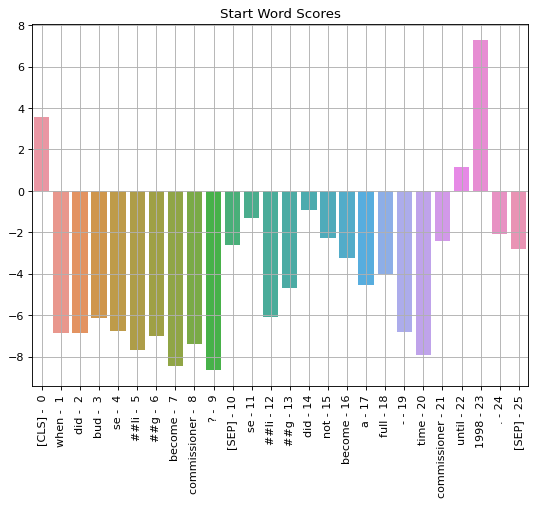

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
# Create a barplot showing the start word score for all of the tokens.
ax = sns.barplot(x=token_labels, y=s_scores, ci=None)

# Turn the xlabels vertical.
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")

# Turn on the vertical grid to help align words to scores.
ax.grid(True)

plt.title('Start Word Scores')

plt.show()

# Visualize BERT attention

In [68]:
# Load model
from bertviz import head_view, model_view
from transformers import BertTokenizer, BertModel
model = BertForQuestionAnswering.from_pretrained("deepset/bert-large-uncased-whole-word-masking-squad2",output_attentions=True)
tokenizer = BertTokenizer.from_pretrained("deepset/bert-large-uncased-whole-word-masking-squad2")

#provide sample sentences for the visualization
sentence_a = "The fox jumped over the dog"
sentence_b = "Sarah's favorite animal is a fox"

#retrieve attention weights
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt')
input_ids = inputs['input_ids']
token_type_ids = inputs['token_type_ids']
attention = model(input_ids, token_type_ids=token_type_ids)[-1]
sentence_b_start = token_type_ids[0].tolist().index(1)
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list) 

In [69]:
#visualize the attention weights
head_view(attention, tokens, sentence_b_start,include_layers=[1])

<IPython.core.display.Javascript object>

# Part 2: QA with website article

### Build function for easy replication

In [ ]:
from collections import OrderedDict
from tqdm import tqdm, trange

In [ ]:
def chunkify(inputs, model, tokenizer, max_len):
    """
    Break up a long article into chunks that fit within the max token
    requirement for that Transformer model.
    """

    # create question mask based on token_type_ids
    # value is 0 for question tokens, 1 for context tokens
    qmask = inputs['token_type_ids'].lt(1)
    qt = torch.masked_select(inputs['input_ids'], qmask)
    chunk_size = max_len - qt.size()[0] - 1  # the "-1" accounts for having to add an ending [SEP] token to the end

    # create a dict of dicts; each sub-dict mimics the structure of pre-chunked model input
    chunked_input = OrderedDict()
    for k, v in inputs.items():
        q = torch.masked_select(v, qmask)
        c = torch.masked_select(v, ~qmask)
        chunks = torch.split(c, chunk_size)

        for i, chunk in enumerate(chunks):
            if i not in chunked_input:
                chunked_input[i] = {}

            thing = torch.cat((q, chunk))
            if i != len(chunks) - 1:
                if k == 'input_ids':
                    thing = torch.cat((thing, torch.tensor([102])))
                else:
                    thing = torch.cat((thing, torch.tensor([1])))

            chunked_input[i][k] = torch.unsqueeze(thing, dim=0)
    return chunked_input

In [ ]:
def answer_my_question(question, text, model, tokenizer, max_len):
    '''
    Takes a question string and a text string 
    and identifies and prints the words within 
    the text that contain the answer.
    '''
    # ======== Tokenize ========
    #Tokenize question and paragraph
    inputs = tokenizer.encode_plus(question, text, return_tensors="pt")
    input_ids = inputs["input_ids"].tolist()[0]
    chunked = False
    if len(input_ids) > max_len:
      inputs = chunkify(inputs, model, tokenizer, max_len)
      chunked = True
    
    #break into chunks if necessary
    if chunked == True:
      answer = ''
      for k, chunk in tqdm(inputs.items(), desc="Getting Answers from Text Chunks"):
          
          # ======== Evaluate ========
          answer_start_scores, answer_end_scores = model(**chunk, return_dict=False)

          # ======== Reconstruct Answer ========
          answer_start = torch.argmax(answer_start_scores)
          answer_end = torch.argmax(answer_end_scores) + 1

          ans = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(chunk['input_ids'][0][answer_start:answer_end]))
          if ans != '[CLS]':
              answer += ans + " / "
      # ======== Print Question and Answer ========
      print('==================')
      print('Question: ' + question)
      print('Answer: ' + answer)
      print('==================')

    else:

      # ======== Evaluate ========
      # Run our question through the model
      answer_start_scores, answer_end_scores = model(**inputs, return_dict=False)

      # ======== Reconstruct Answer ========
      # get the most likely beginning of answer with the argmax of the score
      answer_start = torch.argmax(answer_start_scores)
      # get the most likely end of answer with the argmax of the score    
      answer_end = torch.argmax(answer_end_scores) + 1    
      #get full answer
      the_answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(inputs["input_ids"][0][answer_start:answer_end]))

      # ======== Print Question and Answer ========
      print('==================')
      print('Question: ' + question)
      print('Answer: ' + the_answer)
      print('==================')

### BERT with website article

In [ ]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

url = "https://www.macworld.com/article/671584/history-of-apple-the-story-of-steve-jobs-and-the-company-he-founded.html"
html = urlopen(url).read()
soup = BeautifulSoup(html, features="html.parser")

# remove all script and style elements
for script in soup(["script", "style"]):
    script.extract()

# get text content of the webpage
text = soup.get_text()

# break into lines and remove leading and trailing space on each
lines = (line.strip() for line in text.splitlines())
# break multi-headlines into a line each
chunks = (phrase.strip() for line in lines for phrase in line.split("  "))
# drop blank lines
text = '\n'.join(chunk for chunk in chunks if chunk)

#preview the text content
print(text[1000:])

In [ ]:
model = BertForQuestionAnswering.from_pretrained("deepset/bert-large-uncased-whole-word-masking-squad2")
tokenizer = BertTokenizer.from_pretrained("deepset/bert-large-uncased-whole-word-masking-squad2")
max_len = model.config.max_position_embeddings

question = "When was Apple founded?"
answer_my_question(question, text, model, tokenizer, max_len)

## Part 3: QA with Wikipedia

In [ ]:
!pip install wikipedia

In [ ]:
import wikipedia as wiki

questions = [
    'What author wrote the book "Gone with the Wind"?',
    'What US auto maker produced a car called the Cirrus?',
    'What type of tennis court is Wimbeldon?',
    'What is a smoke-dried jalapeno pepper called?'
]

for question in questions:
    print(f"Question: {question}")
    results = wiki.search(question)

    page = wiki.page(results[0], auto_suggest=False)
    print(f"Top wiki result: {page}")
    print(f"\nThe {results[0]} Wikipedia article contains {len(page.content)} characters.")

    text = page.content

    answer_my_question(question, text, model, tokenizer, max_len)
